In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


Import Modules

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input


Load the Dataset

In [ ]:
data_path = '/content/gdrive/MyDrive/crop_part1'

In [ ]:
# labels - age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(data_path)):
    image_path = os.path.join(data_path, filename)
    temp = filename.split('_')
    age = int(temp[0]) #yas degiskeni
    gender = int(temp[1]) #cinsiyet degiskeni
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/9780 [00:00<?, ?it/s]

In [ ]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,/content/gdrive/MyDrive/crop_part1/62_1_0_2017...,62,1
1,/content/gdrive/MyDrive/crop_part1/85_1_0_2017...,85,1
2,/content/gdrive/MyDrive/crop_part1/75_0_0_2017...,75,0
3,/content/gdrive/MyDrive/crop_part1/53_0_0_2017...,53,0
4,/content/gdrive/MyDrive/crop_part1/7_1_0_20170...,7,1


In [ ]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

Data Analysis

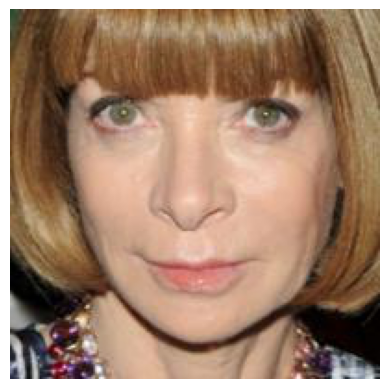

In [ ]:
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);

<Axes: xlabel='age', ylabel='Density'>

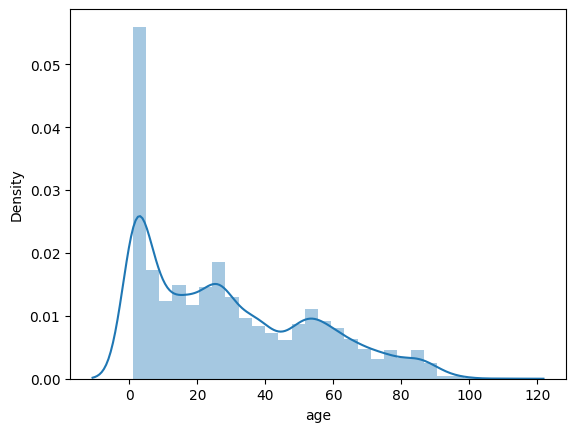

In [ ]:
sns.distplot(df['age'])

<Axes: ylabel='count'>

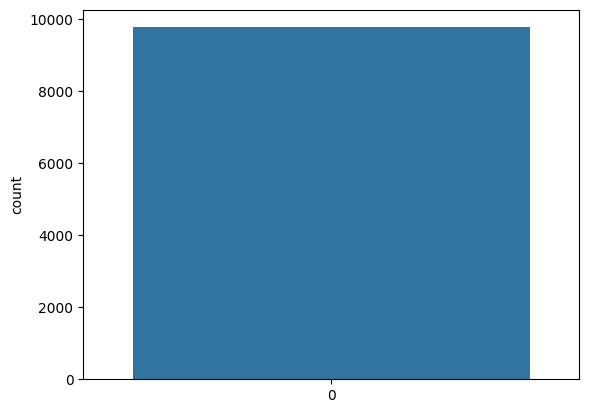

In [ ]:
sns.countplot(df['gender'])

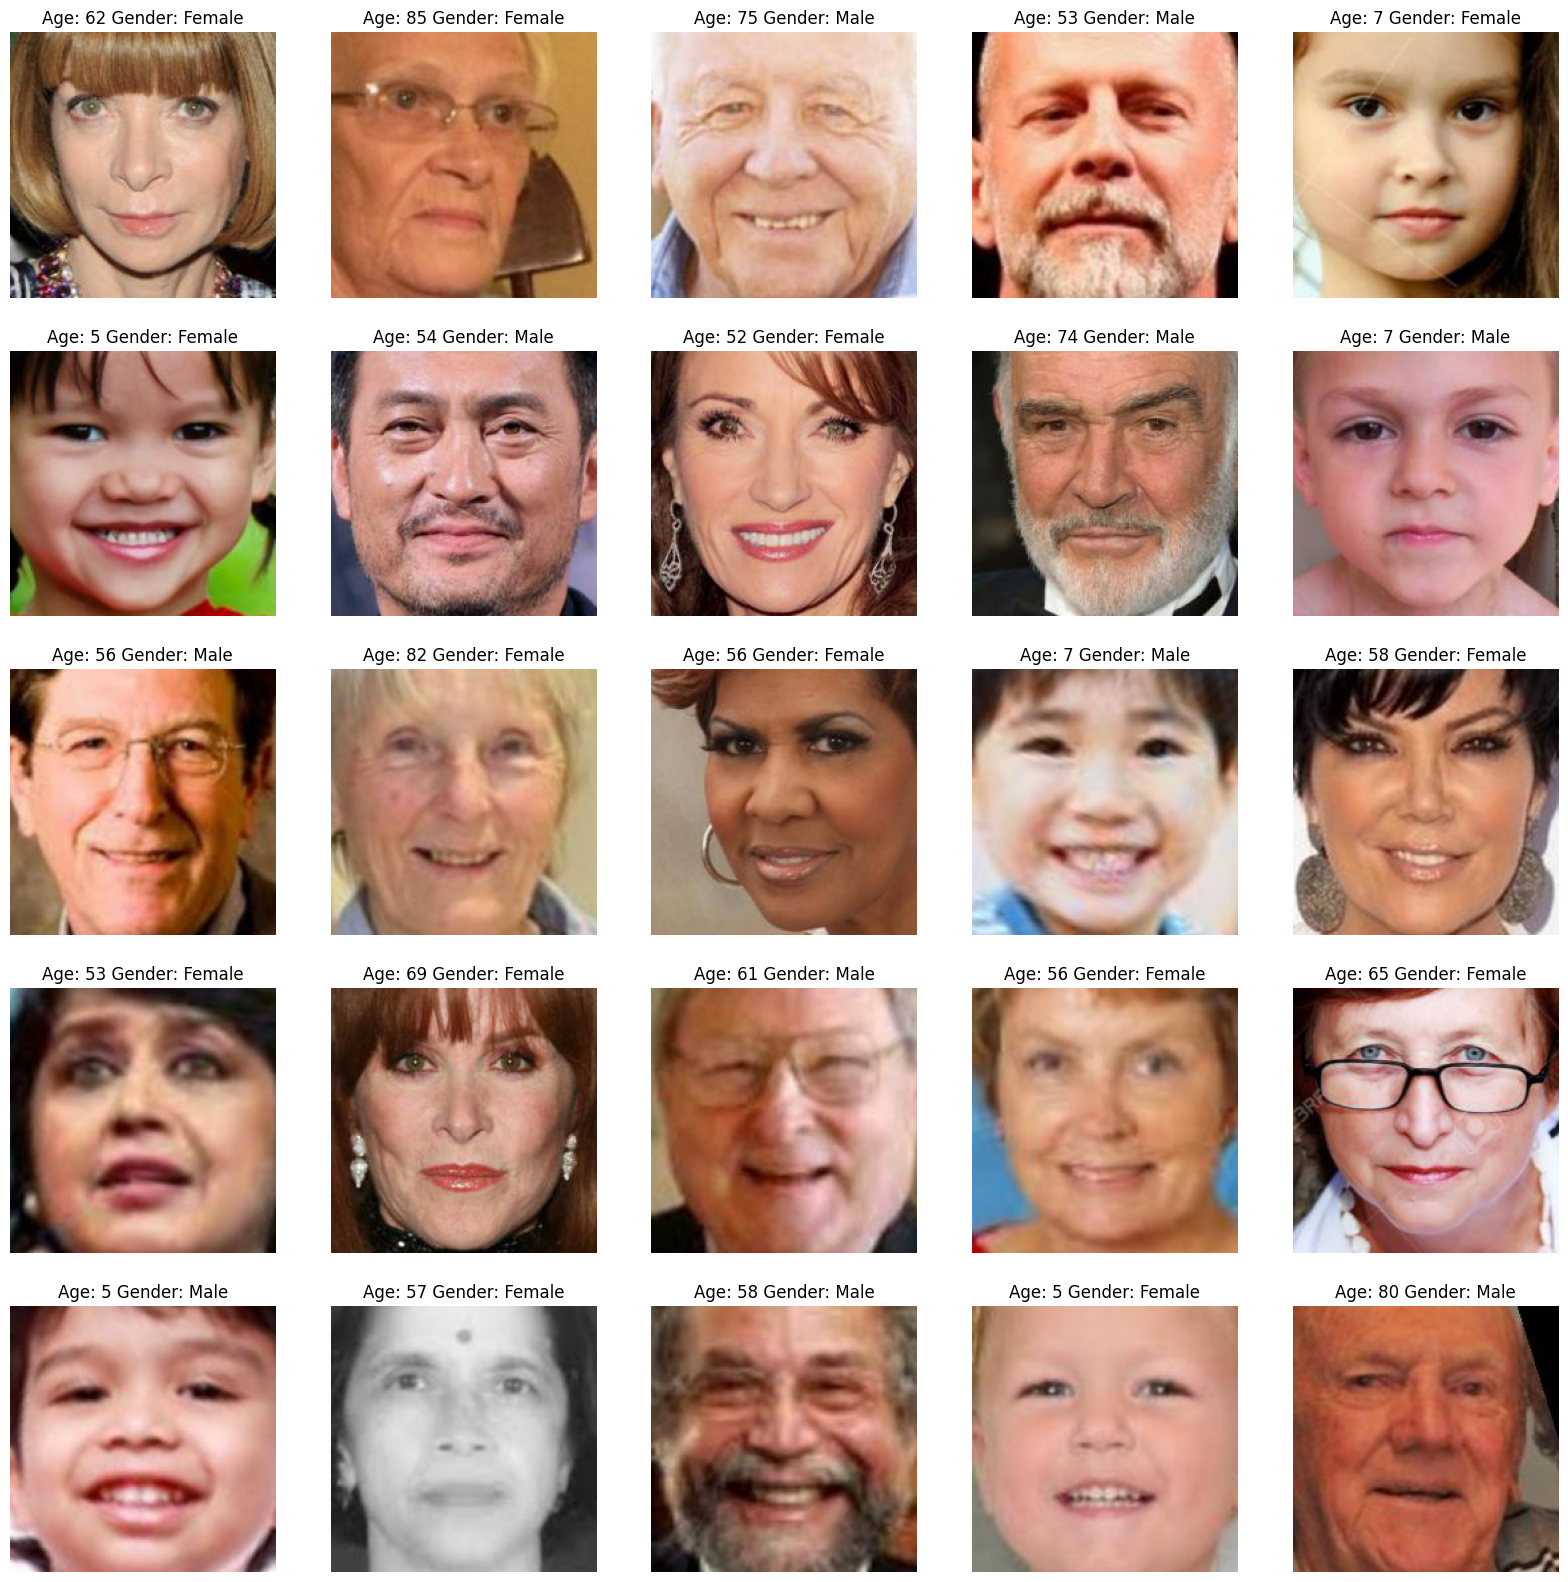

In [ ]:
# to display grid of images
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

Feature Extraction

In [ ]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)

    features = features.reshape(len(features), 128, 128, 1)
    return features

In [ ]:
X = extract_features(df['image'])

  0%|          | 0/9780 [00:00<?, ?it/s]

In [ ]:
X.shape

(9780, 128, 128, 1)

In [ ]:
# normalize the images
X = X/255.0

In [ ]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [ ]:
input_shape = (128, 128, 1)

Model

In [ ]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])


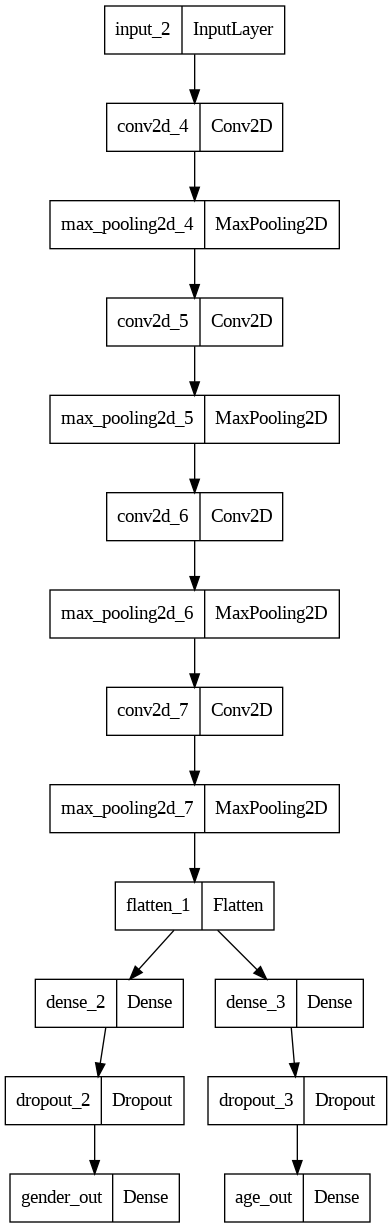

In [ ]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [ ]:
# train model
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2)


Epoch 1/30
245/245 [==============================] - 369s 1s/step - loss: 22.7506 - gender_out_loss: 0.6991 - age_out_loss: 22.0515 - gender_out_accuracy: 0.5700 - age_out_accuracy: 0.0507 - val_loss: 13.4778 - val_gender_out_loss: 0.7004 - val_age_out_loss: 12.7774 - val_gender_out_accuracy: 0.4494 - val_age_out_accuracy: 0.3650
Epoch 2/30
245/245 [==============================] - 360s 1s/step - loss: 17.2758 - gender_out_loss: 0.6228 - age_out_loss: 16.6529 - gender_out_accuracy: 0.6549 - age_out_accuracy: 0.0467 - val_loss: 10.9492 - val_gender_out_loss: 0.6685 - val_age_out_loss: 10.2807 - val_gender_out_accuracy: 0.5164 - val_age_out_accuracy: 0.3170
Epoch 3/30
245/245 [==============================] - 363s 1s/step - loss: 12.3245 - gender_out_loss: 0.5511 - age_out_loss: 11.7733 - gender_out_accuracy: 0.7265 - age_out_accuracy: 0.0473 - val_loss: 12.2612 - val_gender_out_loss: 0.6407 - val_age_out_loss: 11.6205 - val_gender_out_accuracy: 0.5184 - val_age_out_accuracy: 0.3461
E

Plot the Result

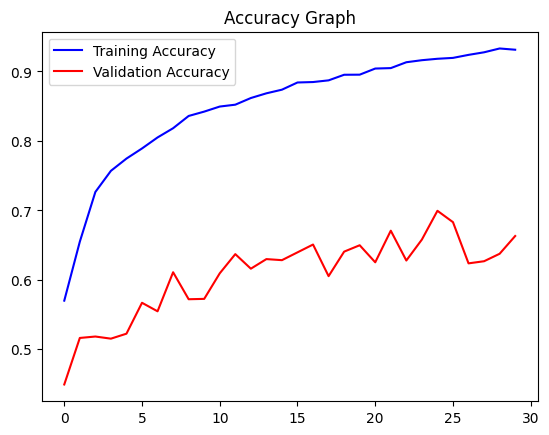

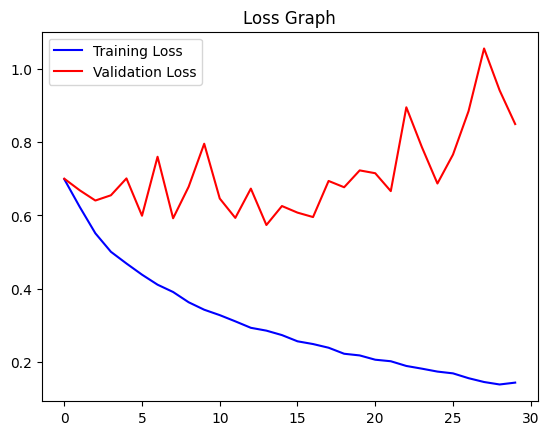

In [ ]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

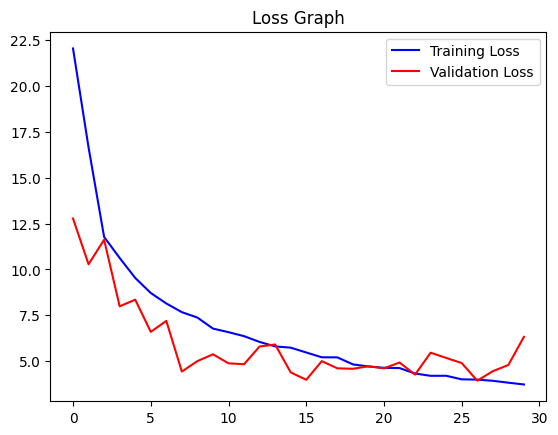

In [ ]:
# plot results for age
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [ ]:
# Function to classify age based on given age value
def classify_age(age):
    if age < 30:
        return "Genç"
    elif age < 60:
        return "Orta Yaşlı"
    else:
        return "Yaşlı"

Prediction with Test Data

Original Gender: Male Original Age: 53 Orta Yaşlı
1/1 [==============================] - 0s 69ms/step
Predicted Gender: Male Predicted Age: 58 Orta Yaşlı


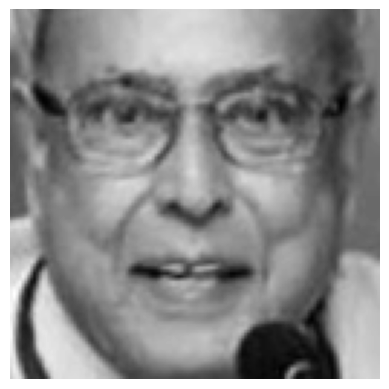

In [ ]:
image_index = 100
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index], classify_age(y_age[image_index]))
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
pred_age_classification = classify_age(pred_age)
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age, pred_age_classification)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 43 Orta Yaşlı
1/1 [==============================] - 0s 62ms/step
Predicted Gender: Male Predicted Age: 39 Orta Yaşlı


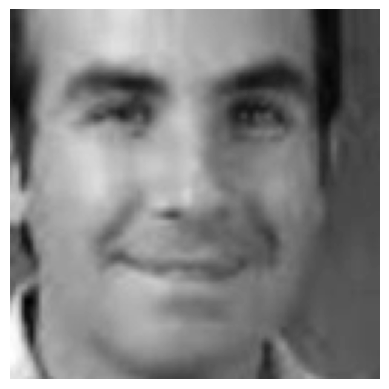

In [ ]:
image_index = 3000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index], classify_age(y_age[image_index]))
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
pred_age_classification = classify_age(pred_age)
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age, pred_age_classification)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Female Original Age: 1 Genç
1/1 [==============================] - 0s 61ms/step
Predicted Gender: Female Predicted Age: 2 Genç


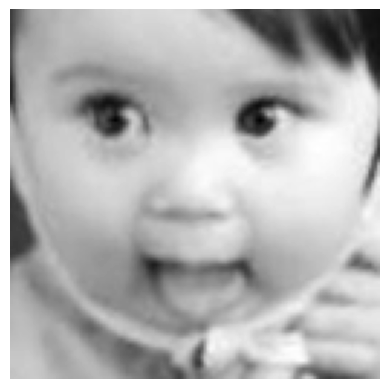

In [ ]:
image_index = 9000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index], classify_age(y_age[image_index]))
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
pred_age_classification = classify_age(pred_age)
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age, pred_age_classification)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');